# Statistical Analysis of YouTube US Trending Videos

# Daniel Riggi

In [1]:
from IPython.display import display, HTML
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.animation as animation
from matplotlib.patches import Patch
from datetime import timedelta
import itertools
import collections
import re
import nltk
import string
import textwrap
from nltk.corpus import stopwords
import sqlite3
from sqlite3 import Error
import os

In [2]:
df = pd.read_csv('../archive/USvideos.csv')

### Functions for working with SQL

In [3]:
def create_connection(db_file, delete_db=False):
    if delete_db and os.path.exists(db_file):
        os.remove(db_file)

    conn = None
    try:
        conn = sqlite3.connect(db_file)
        conn.execute("PRAGMA foreign_keys = 1")
    except Error as e:
        print(e)

    return conn

def create_table(conn, create_table_sql):
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)
        
def execute_sql_statement(sql_statement, conn):
    cur = conn.cursor()
    cur.execute(sql_statement)

    rows = cur.fetchall()

    return rows

### Create non-normalized database

In [4]:
conn = create_connection('../archive/youtube_videos.db', delete_db=True)
df.to_sql('US_Videos', con = conn, if_exists='fail')

In [5]:
sql_statement = "SELECT * from US_Videos;"
sql_df = pd.read_sql_query(sql_statement, conn)
display(sql_df)

index     video_id trending_date  \
0          0  2kyS6SvSYSE      17.14.11   
1          1  1ZAPwfrtAFY      17.14.11   
2          2  5qpjK5DgCt4      17.14.11   
3          3  puqaWrEC7tY      17.14.11   
4          4  d380meD0W0M      17.14.11   
...      ...          ...           ...   
40944  40944  BZt0qjTWNhw      18.14.06   
40945  40945  1h7KV2sjUWY      18.14.06   
40946  40946  D6Oy4LfoqsU      18.14.06   
40947  40947  oV0zkMe1K8s      18.14.06   
40948  40948  ooyjaVdt-jA      18.14.06   

                                                   title  \
0                     WE WANT TO TALK ABOUT OUR MARRIAGE   
1      The Trump Presidency: Last Week Tonight with J...   
2      Racist Superman | Rudy Mancuso, King Bach & Le...   
3                       Nickelback Lyrics: Real or Fake?   
4                               I Dare You: GOING BALD!?   
...                                                  ...   
40944                       The Cat Who Caught the Laser   
40945                         True Facts : Ant Mutualism   
40946  I GAVE SAFIYA NYGAARD A PERFECT HAIR MAKEOVER ...   
40947                How Black Panther Should Have Ended   
40948  Official Call of Duty®: Black Ops 4 — Multipla...   

                  channel_title  category_id              publish_time  \
0                  CaseyNeistat           22  2017-11-13T17:13:01.000Z   
1               LastWeekTonight           24  2017-11-13T07:30:00.000Z   
2                  Rudy Mancuso           23  2017-11-12T19:05:24.000Z   
3         Good Mythical Morning           24  2017-11-13T11:00:04.000Z   
4                      nigahiga           24  2017-11-12T18:01:41.000Z   
...                         ...          ...                       ...   
40944             AaronsAnimals           15  2018-05-18T13:00:04.000Z   
40945                  zefrank1           22  2018-05-18T01:00:06.000Z   
40946                Brad Mondo           24  2018-05-18T17:34:22.000Z   
40947  How It Should Have Ended            1  2018-05-17T17:00:04.000Z   
40948              Call of Duty           20  2018-05-17T17:09:38.000Z   

                                                    tags     views   likes  \
0                                        SHANtell martin    748374   57527   
1      last week tonight trump presidency|"last week ...   2418783   97185   
2      racist superman|"rudy"|"mancuso"|"king"|"bach"...   3191434  146033   
3      rhett and link|"gmm"|"good mythical morning"|"...    343168   10172   
4      ryan|"higa"|"higatv"|"nigahiga"|"i dare you"|"...   2095731  132235   
...                                                  ...       ...     ...   
40944  aarons animals|"aarons"|"animals"|"cat"|"cats"...   1685609   38160   
40945                                             [none]   1064798   60008   
40946  I gave safiya nygaard a perfect hair makeover ...   1066451   48068   
40947  Black Panther|"HISHE"|"Marvel"|"Infinity War"|...   5660813  192957   
40948      call of duty|"cod"|"activision"|"Black Ops 4"  10306119  357079   

       dislikes  comment_count  \
0          2966          15954   
1          6146          12703   
2          5339           8181   
3           666           2146   
4          1989          17518   
...         ...            ...   
40944      1385           2657   
40945       382           3936   
40946      1032           3992   
40947      2846          13088   
40948    212976         144795   

                                       thumbnail_link  comments_disabled  \
0      https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg                  0   
1      https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg                  0   
2      https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg                  0   
3      https://i.ytimg.com/vi/puqaWrEC7tY/default.jpg                  0   
4      https://i.ytimg.com/vi/d380meD0W0M/default.jpg                  0   
...                                               ...                ...   
40

### Create tuples of data to insert into normalized database

In [6]:
#category tuple
with open('../archive/US_category_id.json') as f:
    data = json.load(f)
lst = []
for d in data['items']:
    category = d['snippet']['title']
    tup = (int(d['id']), category)
    lst.append(tup)
cat_tup = tuple(lst)

##### Create video, tag, and trending dates tuples together. An Issue arose with videos having slightly different titles, but the same video_id (because the primary key needs to be unique). To keep these entries, I add an underscore plut digit to the end of the video id. The digit ranges from 2, to the amount of different times the same video was in the database with different titles. 

In [7]:
#video, tag, and trending dates tuple

def create_vid_tag_dates_tup(df):
    df = df[['video_id', 'title', 'category_id', 'publish_time',
            'tags','trending_date','views', 'likes', 'dislikes', 'comment_count']]
    vid_lst = []
    tag_lst = []
    dates_lst = []
    id_lst = []
    count = 0
    count2 = 0
    for i in range(0, len(df)):
        count2 += 1
        v_id = df.iloc[i,0]
        title = df.iloc[i,1]
        cat_id = df.iloc[i,2]
        pub_time = df.iloc[i,3]
        tags = df.iloc[i,4].split('|')
        trend_date = df.iloc[i,5]
        views = int(df.iloc[i,6])
        likes = int(df.iloc[i,7])
        dislikes = int(df.iloc[i,8])
        cc = int(df.iloc[i,9])
        vid_tup = (v_id, title, int(cat_id), pub_time)
        if vid_tup in vid_lst:                                 #excludes identical entries from different days
            dates_tup = (count2, v_id, trend_date, views, likes, dislikes, cc)
            dates_lst.append(dates_tup)
            continue
        elif v_id in id_lst:
            num = 2
            while v_id in id_lst:                           
                v_id = f'{v_id[0:11]}_{num}' 
                num += 1
            vid_tup = (v_id, title, int(cat_id), pub_time)
            vid_lst.append(vid_tup)
            id_lst.append(v_id)
            dates_tup = (count2, v_id, trend_date, views, likes, dislikes, cc)
            dates_lst.append(dates_tup)
        else:
            vid_lst.append(vid_tup) 
            id_lst.append(v_id)
            dates_tup = (count2, v_id, trend_date, views, likes, dislikes, cc)
            dates_lst.append(dates_tup)
        for tag in tags:
            tag = tag.strip('"')
            count += 1
            tag_tup = (count, v_id, tag.strip())
            tag_lst.append(tag_tup)
    return tuple(vid_lst), tuple(tag_lst), tuple(dates_lst)

vid_tup, tag_tup, dates_tup = create_vid_tag_dates_tup(sql_df)

### Create tables and define insert functions 

In [8]:
create_category_table = """CREATE TABLE [Categories](
    [Category_ID] int NOT NULL PRIMARY KEY, 
    [Category] text NOT NULL);"""

def insert_categories(conn, values):
    sql = '''INSERT INTO Categories(Category_ID, Category)
            Values(?, ?);'''
    cur = conn.cursor()
    cur.execute(sql, values)
    return cur.lastrowid

create_tags_table = """CREATE TABLE [Tags](
    [PK] int NOT NULL PRIMARY KEY,
    [Video_ID] text,
    [Tag] text,
    FOREIGN KEY(Video_ID) REFERENCES USVideos(Video_ID));"""

def insert_tags(conn, values):
    sql = '''INSERT INTO Tags(PK, Video_ID, Tag)
            VALUES(?, ?, ?);'''
    cur = conn.cursor()
    cur.execute(sql, values)
    return cur.lastrowid

create_trending_dates_table = """CREATE TABLE [Trending_Dates](
    [PK] int NOT NULL PRIMARY KEY,
    [Video_ID] text,
    [Trending_Date] text,
    [Views] int,
    [Likes] int,
    [Dislikes] int, 
    [Comment_Count] int,
    FOREIGN KEY(Video_ID) REFERENCES USVideos(Video_ID));"""

def insert_trend_dates(conn, values):
    sql = '''INSERT INTO Trending_Dates(PK, Video_ID, Trending_date, Views, Likes, Dislikes, Comment_Count)
            VALUES(?, ?, ?, ?, ?, ?, ?);'''
    cur = conn.cursor()
    cur.execute(sql, values)
    return cur.lastrowid

create_videos_table ='''CREATE TABLE[USVideos](
        [Video_ID] text NOT NULL PRIMARY KEY,
        [Category_ID] int NOT NULL,
        [Title] text NOT NULL,
        [Publish_Time] text,
        FOREIGN KEY(Category_ID) REFERENCES Categories(Category_ID));'''

def insert_videos(conn, values):
    sql = '''INSERT INTO USVideos(Video_ID, Title, Category_ID, Publish_Time)
            VALUES(?, ?, ?, ?);'''
    cur = conn.cursor()
    cur.execute(sql, values)
    return cur.lastrowid

### Insert data into tables

In [9]:
conn = create_connection('../archive/youtube_videos.db')
create_table(conn, create_category_table)
create_table(conn, create_tags_table)
create_table(conn, create_trending_dates_table)
create_table(conn, create_videos_table)
for val in cat_tup:
    insert_categories(conn, val)
conn.commit()
cat_sql = '''SELECT * FROM Categories;'''
cat_df = pd.read_sql_query(cat_sql, conn)
display(cat_df)

Category_ID               Category
0             1       Film & Animation
1             2       Autos & Vehicles
2            10                  Music
3            15         Pets & Animals
4            17                 Sports
5            18           Short Movies
6            19        Travel & Events
7            20                 Gaming
8            21          Videoblogging
9            22         People & Blogs
10           23                 Comedy
11           24          Entertainment
12           25        News & Politics
13           26          Howto & Style
14           27              Education
15           28   Science & Technology
16           29  Nonprofits & Activism
17           30                 Movies
18           31        Anime/Animation
19           32       Action/Adventure
20           33               Classics
21           34                 Comedy
22           35            Documentary
23           36                  Drama
24           37                 Family
25           38                Foreign
26           39                 Horror
27           40         Sci-Fi/Fantasy
28           41               Thriller
29           42                 Shorts
30           43                  Shows
31           44               Trailers

In [10]:
for val in vid_tup:
    insert_videos(conn, val)
conn.commit()
vid_sql = '''SELECT * FROM USVideos LIMIT 10'''
vid_df = pd.read_sql_query(vid_sql, conn)
display(vid_df)

Video_ID  Category_ID  \
0  2kyS6SvSYSE           22   
1  1ZAPwfrtAFY           24   
2  5qpjK5DgCt4           23   
3  puqaWrEC7tY           24   
4  d380meD0W0M           24   
5  gHZ1Qz0KiKM           28   
6  39idVpFF7NQ           24   
7  nc99ccSXST0           28   
8  jr9QtXwC9vc            1   
9  TUmyygCMMGA           25   

                                               Title              Publish_Time  
0                 WE WANT TO TALK ABOUT OUR MARRIAGE  2017-11-13T17:13:01.000Z  
1  The Trump Presidency: Last Week Tonight with J...  2017-11-13T07:30:00.000Z  
2  Racist Superman | Rudy Mancuso, King Bach & Le...  2017-11-12T19:05:24.000Z  
3                   Nickelback Lyrics: Real or Fake?  2017-11-13T11:00:04.000Z  
4                           I Dare You: GOING BALD!?  2017-11-12T18:01:41.000Z  
5                              2 Weeks with iPhone X  2017-11-13T19:07:23.000Z  
6          Roy Moore & Jeff Sessions Cold Open - SNL  2017-11-12T05:37:17.000Z  
7                5 Ice Cream Gadgets put to the Test  2017-11-12T21:50:37.000Z  
8  The Greatest Showman | Official Trailer 2 [HD]...  2017-11-13T14:00:23.000Z  
9  Why the rise of the robots won’t mean the end ...  2017-11-13T13:45:16.000Z

In [11]:
for val in tag_tup:
    insert_tags(conn, val)
conn.commit()
tag_sql = '''SELECT * FROM Tags LIMIT 10;'''
tag_df = pd.read_sql_query(tag_sql, conn)
display(tag_df)

PK     Video_ID                                 Tag
0   1  2kyS6SvSYSE                     SHANtell martin
1   2  1ZAPwfrtAFY  last week tonight trump presidency
2   3  1ZAPwfrtAFY      last week tonight donald trump
3   4  1ZAPwfrtAFY                   john oliver trump
4   5  1ZAPwfrtAFY                        donald trump
5   6  5qpjK5DgCt4                     racist superman
6   7  5qpjK5DgCt4                                rudy
7   8  5qpjK5DgCt4                             mancuso
8   9  5qpjK5DgCt4                                king
9  10  5qpjK5DgCt4                                bach

In [12]:
for val in dates_tup:
    insert_trend_dates(conn, val)
conn.commit()
date_sql = '''SELECT * FROM Trending_Dates;'''
date_df = pd.read_sql_query(date_sql, conn)
display(date_df)

PK     Video_ID Trending_Date     Views   Likes  Dislikes  \
0          1  2kyS6SvSYSE      17.14.11    748374   57527      2966   
1          2  1ZAPwfrtAFY      17.14.11   2418783   97185      6146   
2          3  5qpjK5DgCt4      17.14.11   3191434  146033      5339   
3          4  puqaWrEC7tY      17.14.11    343168   10172       666   
4          5  d380meD0W0M      17.14.11   2095731  132235      1989   
...      ...          ...           ...       ...     ...       ...   
40944  40945  BZt0qjTWNhw      18.14.06   1685609   38160      1385   
40945  40946  1h7KV2sjUWY      18.14.06   1064798   60008       382   
40946  40947  D6Oy4LfoqsU      18.14.06   1066451   48068      1032   
40947  40948  oV0zkMe1K8s      18.14.06   5660813  192957      2846   
40948  40949  ooyjaVdt-jA      18.14.06  10306119  357079    212976   

       Comment_Count  
0              15954  
1              12703  
2               8181  
3               2146  
4              17518  
...              ...  
40944           2657  
40945           3936  
40946           3992  
40947          13088  
40948         144795  

[40949 rows x 7 columns]

# EDA/Visualizations
### Top videos by views:

In [13]:
pd.set_option('display.max_colwidth',50)
conn = create_connection('../archive/youtube_videos.db')

In [14]:
top_views = '''SELECT usv.Title, td.Views  
               FROM Trending_Dates td
               JOIN USVideos usv on td.Video_ID = usv.Video_ID
               GROUP BY Title
               ORDER BY Views DESC
               LIMIT 20;'''
top_views_df = pd.read_sql_query(top_views, conn)
display(top_views_df)

Title     Views
0               Maluma - El Préstamo (Official Video)  48431654
1                 BTS (방탄소년단) 'FAKE LOVE' Official MV  39349927
2                             TWICE What is Love? M/V  38873543
3   Marvel Studios' Avengers: Infinity War Officia...  37736281
4         Ed Sheeran - Perfect (Official Music Video)  33523622
5   Childish Gambino - This Is America (Official V...  31648454
6                       VENOM - Official Trailer (HD)  27973210
7   YouTube Rewind: The Shape of 2017 | #YouTubeRe...  24782158
8                               Drake - Nice For What  24421448
9   Sanju | Official Trailer | Ranbir Kapoor | Raj...  23758250
10  周杰倫 Jay Chou【不愛我就拉倒 If You Don't Love Me, It's...  21957640
11                                    To Our Daughter  20921796
12  Migos, Nicki Minaj, Cardi B - MotorSport (Offi...  20136000
13  Marvel Studios' Avengers: Infinity War - Offic...  19716689
14  Sanju | Official Teaser | Ranbir Kapoor | Rajk...  18639195
15                             TWICE Heart Shaker M/V  18195959
16  Jurassic World: Fallen Kingdom - Official Trai...  18184886
17         Eminem - Walk On Water (Audio) ft. Beyoncé  17158531
18                                        we broke up  16884972
19               Ariana Grande - No Tears Left To Cry  15873034

### Top videos by likes:

In [15]:
top_likes = '''SELECT usv.Title, td.Likes  
               FROM Trending_Dates td
               JOIN USVideos usv on td.Video_ID = usv.Video_ID
               GROUP BY usv.Title
               ORDER BY Likes DESC
               LIMIT 20;'''
top_likes_df = pd.read_sql_query(top_likes, conn)
display(top_likes_df)

Title    Likes
0                 BTS (방탄소년단) 'FAKE LOVE' Official MV  3880071
1   BTS (방탄소년단) 'MIC Drop (Steve Aoki Remix)' Offi...  2055137
2                          j-hope 'Daydream (백일몽)' MV  2050527
3   BTS (방탄소년단) LOVE YOURSELF 轉 Tear 'Singularity'...  1956202
4   Marvel Studios' Avengers: Infinity War Officia...  1735895
5         Ed Sheeran - Perfect (Official Music Video)  1634124
6   BTS (방탄소년단) 'Euphoria : Theme of LOVE YOURSELF...  1572997
7   BTS (방탄소년단) 'FAKE LOVE' Official MV (Extended ...  1437859
8   Childish Gambino - This Is America (Official V...  1405355
9                                j-hope 'Airplane' MV  1401915
10               Ariana Grande - No Tears Left To Cry  1386616
11                                        we broke up  1366736
12          BTS (방탄소년단) 'FAKE LOVE' Official Teaser 2  1290509
13                                LOGAN PAUL IS BACK!  1207457
14                         Suicide: Be Here Tomorrow.  1167488
15  YouTube Rewind: The Shape of 2017 | #YouTubeRe...  1149185
16                            TWICE What is Love? M/V  1111592
17     Taylor Swift - End Game ft. Ed Sheeran, Future  1065777
18                            Taylor Swift - Delicate   983693
19  Marvel Studios' Avengers: Infinity War - Offic...   975715

### Videos with the most comments:

In [16]:
most_comments = '''SELECT td.Comment_Count as Comments, usv.Title
                   FROM USVideos usv
                   JOIN Trending_Dates td on td.Video_ID = usv.Video_ID
                   GROUP BY usv.Title
                   ORDER BY Comment_Count DESC
                   LIMIT 20'''
top_likes_df = pd.read_sql_query(most_comments, conn)
display(top_likes_df)

Comments                                              Title
0     733373                                          So Sorry.
1     692305                BTS (방탄소년단) 'FAKE LOVE' Official MV
2     462103  YouTube Rewind: The Shape of 2017 | #YouTubeRe...
3     432534                                LOGAN PAUL IS BACK!
4     395562  BTS (방탄소년단) 'MIC Drop (Steve Aoki Remix)' Offi...
5     387384                         j-hope 'Daydream (백일몽)' MV
6     363133                         Suicide: Be Here Tomorrow.
7     321455       Melting Every Lipstick From Sephora Together
8     285583  BTS (방탄소년단) LOVE YOURSELF 轉 Tear 'Singularity'...
9     241237  Marvel Studios' Avengers: Infinity War Officia...
10    237907                                        we broke up
11    206632                            TWICE What is Love? M/V
12    180262  BTS (방탄소년단) 'Euphoria : Theme of LOVE YOURSELF...
13    179396  MOMMY AND DAUGHTER SURPRISE DADDY WITH PREGNAN...
14    171128  NEW WET N WILD 'GOTH-O-GRAPHIC' COLLECTION | H...
15    167199                                  RIP ANGRY GRANDPA
16    158127                               j-hope 'Airplane' MV
17    150036                                      GOT7 Look M/V
18    149473  Childish Gambino - This Is America (Official V...
19    141630               Ariana Grande - No Tears Left To Cry

## Examine most frequent words in tags

In [17]:
get_tags = '''SELECT Tag FROM Tags'''
tag_df = pd.read_sql_query(get_tags, conn)
tag_df.head()

Tag
0                     SHANtell martin
1  last week tonight trump presidency
2      last week tonight donald trump
3                   john oliver trump
4                        donald trump

[nltk_data] Downloading package stopwords to /home/daniel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


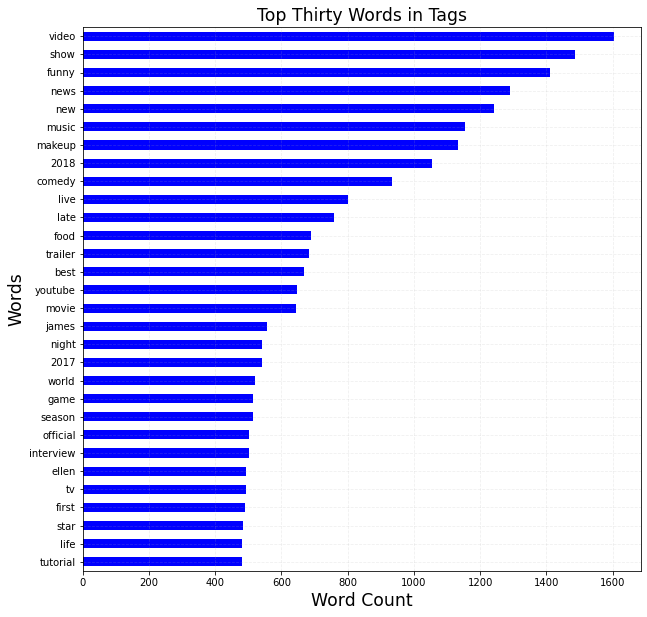

In [18]:
tag_lst = list(tag_df['Tag'])

#split each tag and remove capitals
words_lower = [tag.lower().split() for tag in tag_lst]

#flatten the list
words_lower = list(itertools.chain(*words_lower))

#remove stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

words_lower = [word for word in words_lower if word not in stop_words]

#create couner
word_count = collections.Counter(words_lower)

#put top 50 words and their count into dataframe
top_30 = pd.DataFrame(word_count.most_common(30),
                     columns = ['words', 'count'])

#plot
fig, ax = plt.subplots(figsize=(10, 10))

top_30.sort_values(by='count').plot.barh(x='words',
                   y = 'count',
                   ax = ax,
                   color = 'blue')

ax.set_title('Top Thirty Words in Tags', fontsize = 'xx-large')
plt.xlabel('Word Count', fontsize = 'xx-large')
plt.ylabel('Words', fontsize = 'xx-large')
ax.get_legend().remove()
plt.grid(linestyle = '--', alpha= 0.2)
plt.show()

### Do the same for the titles:

In [19]:
get_titles = '''SELECT Title from USVideos;'''
title_df = pd.read_sql_query(get_titles, conn)
title_df.head()

Title
0                 WE WANT TO TALK ABOUT OUR MARRIAGE
1  The Trump Presidency: Last Week Tonight with J...
2  Racist Superman | Rudy Mancuso, King Bach & Le...
3                   Nickelback Lyrics: Real or Fake?
4                           I Dare You: GOING BALD!?

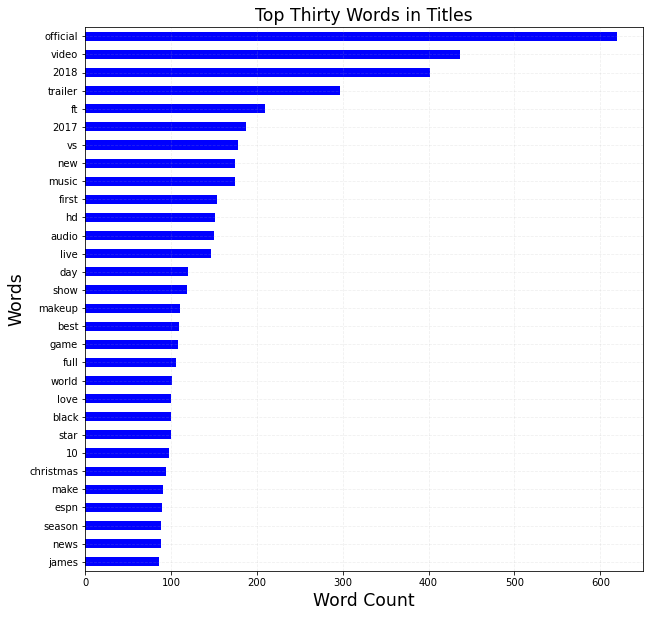

In [35]:
title_lst = list(title_df['Title'])

#split each tag and remove capitals
titles_lower = [title.lower().split() for title in title_lst]

#flatten the list
titles_lower = list(itertools.chain(*titles_lower))

#remove stop words
titles_lower = [word for word in titles_lower if word not in stop_words]

lst = []
for word in titles_lower:
    word = re.sub(r'[^\w\s]','', word)
    if len(word) <= 1:
        continue
    else:
        lst.append(word)
titles_lower = lst

#create couner
title_count = collections.Counter(titles_lower)

#put top 30 words and their count into dataframe
top_30 = pd.DataFrame(title_count.most_common(30),
                     columns = ['words', 'count'])

#plot
fig, ax = plt.subplots(figsize=(10, 10))

top_30.sort_values(by='count').plot.barh(x='words',
                   y = 'count',
                   ax = ax,
                   color = 'blue')

ax.set_title('Top Thirty Words in Titles', fontsize = 'xx-large')
plt.xlabel('Word Count', fontsize = 'xx-large')
plt.ylabel('Words', fontsize = 'xx-large')
ax.get_legend().remove()
plt.grid(linestyle = '--', alpha= 0.2)
plt.show()

## Let's look at videos by category

In [21]:
count_category = '''SELECT c.Category, COUNT(usv.Category_id) as Count
                    FROM Categories c
                    JOIN USVideos usv ON usv.Category_id = c.Category_id
                    GROUP BY c.Category
                    ORDER BY Count DESC;'''
cat_count_df = pd.read_sql_query(count_category, conn)

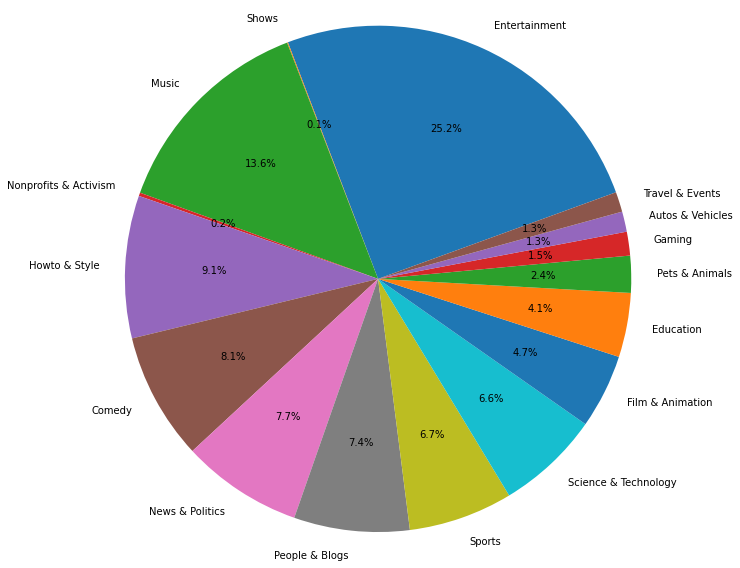

<Figure size 432x288 with 0 Axes>

In [22]:
labels = list(cat_count_df['Category'])
sizes = list(cat_count_df['Count'])

#reorder the two smallest slices to avoid label overlap
idxs = [1,3]
for i in idxs:
    labels.insert(i, labels[-1])
    sizes.insert(i, sizes[-1])
    sizes.pop()
    labels.pop()
    
fig, ax = plt.subplots(figsize = (10,10))
ax.pie(sizes, labels=labels, autopct = '%1.1f%%', pctdistance=0.65, startangle=20)
ax.axis('equal')
#ax.set_title("Percent of Total Videos By Category", fontsize='xx-large')
plt.show()
plt.tight_layout()

### Barchart Race of Top Videos By Views

In [23]:
top_views = '''SELECT usv.Title, usv.Category_ID as Category, td.Views, td.Trending_Date as Date  
               FROM Trending_Dates td
               JOIN USVideos usv on td.Video_ID = usv.Video_ID;'''
top_views_df = pd.read_sql_query(top_views, conn)
top_views_df['Date'] = pd.to_datetime(top_views_df['Date'], format = '%y.%d.%m')
display(top_views_df)

Title  Category     Views  \
0                     WE WANT TO TALK ABOUT OUR MARRIAGE        22    748374   
1      The Trump Presidency: Last Week Tonight with J...        24   2418783   
2      Racist Superman | Rudy Mancuso, King Bach & Le...        23   3191434   
3                       Nickelback Lyrics: Real or Fake?        24    343168   
4                               I Dare You: GOING BALD!?        24   2095731   
...                                                  ...       ...       ...   
40944                       The Cat Who Caught the Laser        15   1685609   
40945                         True Facts : Ant Mutualism        22   1064798   
40946  I GAVE SAFIYA NYGAARD A PERFECT HAIR MAKEOVER ...        24   1066451   
40947                How Black Panther Should Have Ended         1   5660813   
40948  Official Call of Duty®: Black Ops 4 — Multipla...        20  10306119   

            Date  
0     2017-11-14  
1     2017-11-14  
2     2017-11-14  
3     2017-11-14  
4     2017-11-14  
...          ...  
40944 2018-06-14  
40945 2018-06-14  
40946 2018-06-14  
40947 2018-06-14  
40948 2018-06-14  

[40949 rows x 4 columns]

In [24]:
#Get colors from color map and create a dictionary matching to different video categories
colors = list(plt.cm.rainbow(range(0, 342, 19))) #19*18 = 342, there are 18 categories. Trial and error for correct spacing
categories = list(top_views_df['Category'].unique())
color_dic = dict(zip(categories, colors))
days = list(top_views_df['Date'].unique())

### Clean the music video titles 

In [25]:
def clean_titles(title_lst, width_lst):
    lst = []
    max_width = max(width_lst)
    for title, width in zip(title_lst, width_lst):
        title = title.encode("ascii", "ignore")
        title = title.decode()
        title = title.replace('(Official Video)', '').replace("(Official Music Video)", '').replace("[Official Audio]",'')
        title = title.replace(" ()", '').replace("[Official Music video]", '').replace("(Official)", '')
        title = title.replace("at the 2018 Golden Globes", '').replace("| Releasing on 29th June", '').replace("[Official Music Video]",'')
        
        #wrap texts different amount based off how long the text is, as well as how wide it's bar is
        #the bar width depends on the max bar width of the current graph
        if width < (.09 * max_width):
            title = '\n'.join(textwrap.wrap(title, 10))
        elif width < (.15 * max_width) and len(title) > 13:
            title = '\n'.join(textwrap.wrap(title, 15))
        elif width < (.2*max_width) and len(title) > 20:
            title = '\n'.join(textwrap.wrap(title, 20))
        elif width < (.3*max_width) and len(title) > 40:
            title = '\n'.join(textwrap.wrap(title, 30))
        elif width < (.4*max_width) and len(title) > 40:
            title = '\n'.join(textwrap.wrap(title, 40))
        elif width < (.5*max_width) and len(title) > 70:
            title = '\n'.join(textwrap.wrap(title, 50))
        lst.append(title)   
    return lst

In [26]:
#dictionary of category ID's to categories for the legend
cat_sql = f'''SELECT Category_ID, Category FROM Categories
            WHERE Category_ID IN {tuple(categories)};'''
cat_df = pd.read_sql_query(cat_sql, conn)
category_dic = {k:v for k, v in zip(cat_df['Category_ID'], cat_df['Category'])}

In [27]:
#Function to create legend handles
def make_legend_elements(color_dic, category_dic):
    lst = []
    for k in color_dic.keys():
        lst.append(Patch(facecolor=color_dic[k], edgecolor='slategrey', label = category_dic[k]))
    return lst

legend_handles = make_legend_elements(color_dic, category_dic)

In [28]:
def plot_horz_bar(current_day):
    #get top five values 
    to_plot = top_views_df[top_views_df['Date'] == current_day].sort_values(by='Views', ascending=False).iloc[0:5,:]
    to_plot = to_plot[::-1] 
    y = to_plot['Title']
    width = to_plot['Views']
    ylabs = list(y)
    ylabs = clean_titles(ylabs, width)
    ax.clear()
    ax.barh(y=y, width=width, color=[color_dic[cat_num] for cat_num in list(to_plot['Category'])], edgecolor='slategrey')
    
    #for loop to add the text on the bars
    for idx, (val, name) in enumerate(zip(width, ylabs)):
        ax.text(val - 160000, idx-.08, name, size=14, weight= 600, ha='right', va='center')
        
    ax.set_yticks([])
    #add the current date on the right side of plot
    ax.text(1, 0.5, np.datetime_as_string(current_day, unit='D'),
            transform=ax.transAxes, size=30, ha='right', color='dimgrey', weight=600)
    ax.xaxis.set_ticks_position('top')
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
    ax.tick_params(axis='x', labelsize=15)
    ax.grid(True, axis='x',color='lightgray', linewidth=2)
    ax.text(0, 1.1, 'Top Five Trending Videos by Views from 11/14/2017 to 06/14/2018', transform=ax.transAxes, size = 20, weight=500)
    cat_dict = dict(cat_tup)
    legend_labels = [str(cat_dict[i]) for i in color_dic.keys()]
    legend_colors = [color_dic[i] for i in color_dic.keys()]
    plt.margins(y=.01)
    ax.legend(handles=legend_handles, ncol = 2, fontsize='large', loc = 4)
    plt.box(False)

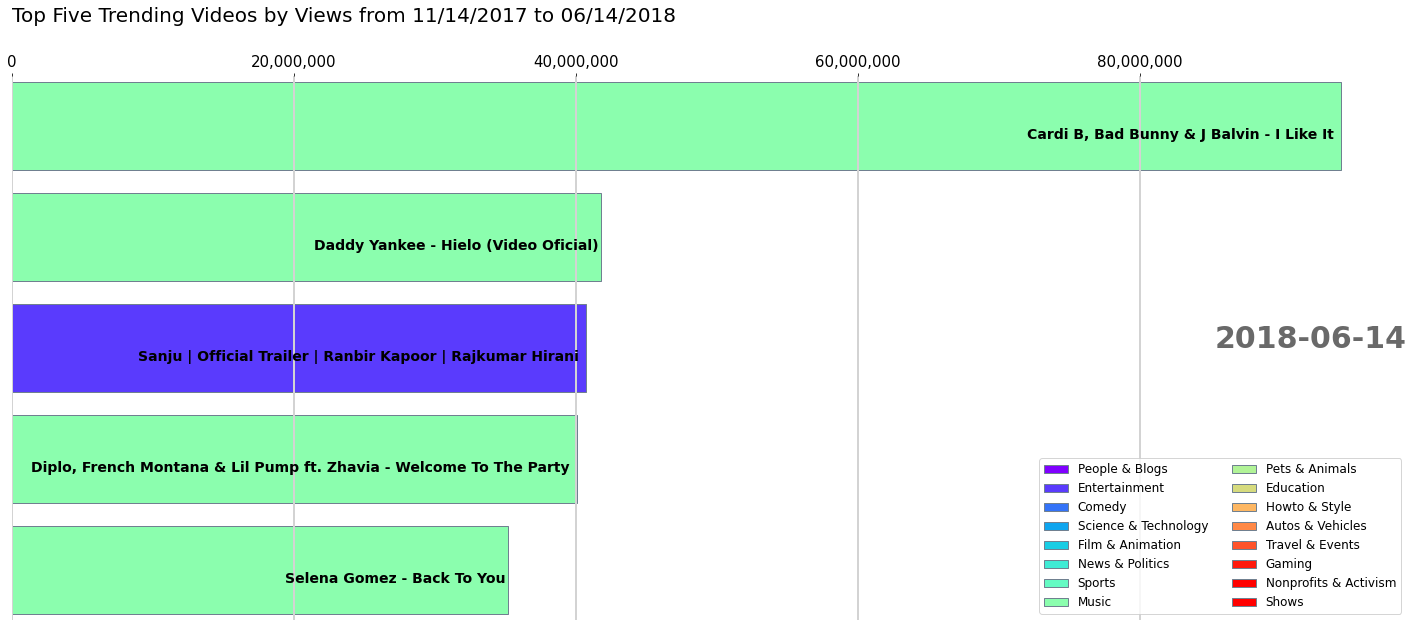

In [29]:
fig, ax = plt.subplots(figsize = (25, 10))
animator = animation.FuncAnimation(fig, plot_horz_bar, frames=days[0::3], interval=2000, save_count = 50)
HTML(animator.to_jshtml())

## Look at a histogram of when videos were published

In [30]:
pub_time = '''SELECT Distinct Title, Publish_Time FROM USVideos;'''
pt_df = pd.read_sql_query(pub_time, conn)
display(pt_df)

Title  \
0                    WE WANT TO TALK ABOUT OUR MARRIAGE   
1     The Trump Presidency: Last Week Tonight with J...   
2     Racist Superman | Rudy Mancuso, King Bach & Le...   
3                      Nickelback Lyrics: Real or Fake?   
4                              I Dare You: GOING BALD!?   
...                                                 ...   
6459                      CRAYOLA MAKEUP | HIT OR MISS?   
6460  First Take reacts: Kyrie Irving says contract ...   
6461  Drop the Mic w/ Ashton Kutcher & Sean Diddy Combs   
6462  Carla Makes BA Smashburgers | From the Test Ki...   
6463  Katherine Langford on 13 Reasons Why, Australi...   

                  Publish_Time  
0     2017-11-13T17:13:01.000Z  
1     2017-11-13T07:30:00.000Z  
2     2017-11-12T19:05:24.000Z  
3     2017-11-13T11:00:04.000Z  
4     2017-11-12T18:01:41.000Z  
...                        ...  
6459  2018-06-12T18:55:26.000Z  
6460  2018-06-13T15:06:08.000Z  
6461  2018-06-13T05:27:27.000Z  
6462  2018-06-12T16:03:58.000Z  
6463  2018-06-13T09:00:06.000Z  

[6464 rows x 2 columns]

In [31]:
#Change the publish time column to datetime objects, subtract 5 hours to change from Zulu time to EST
pt_df['Publish_Time'] = pt_df['Publish_Time'].astype("datetime64") - timedelta(hours=5)

In [32]:
pt_df['hour'] = pt_df['Publish_Time'].dt.hour + round((pt_df['Publish_Time'].dt.minute)/60, 2)

Text(0, 0.5, 'Frequency')

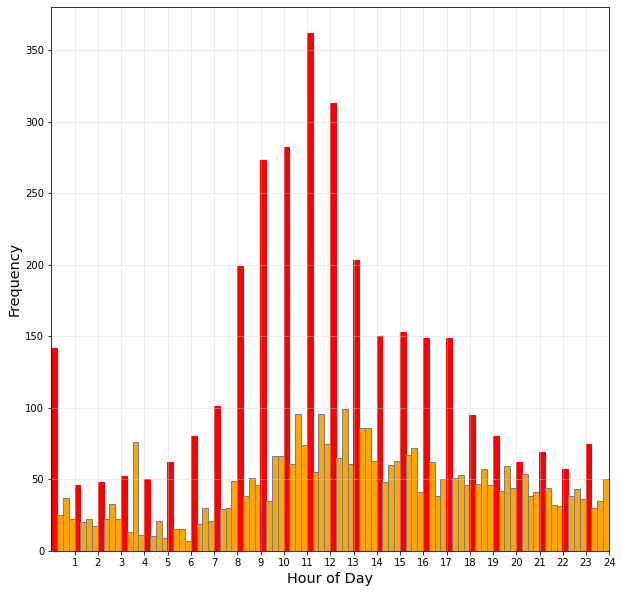

In [33]:
fig, ax = plt.subplots(figsize = (10,10))
ax.set_xlim([0, 24])
N, bins, patches = ax.hist(pt_df['hour'], bins=96, color='orange', edgecolor='slategrey')
for i in range(0, 96, 4):
    patches[i].set_color('r')
_ = ax.set_xticks(range(1, 25))
ax.grid(True, color = 'lightgray', alpha=.5)
ax.set_xlabel("Hour of Day", fontsize = 'x-large')
ax.set_ylabel("Frequency", fontsize= 'x-large')
#_ = ax.set_title("Time of Day Videos Published", fontsize = 'xx-large')

### Videos With No Comments

In [34]:
views_sql = '''SELECT DISTINCT video_id, title FROM Trending_Dates inner join USVideos using(video_ID)
where comment_count = (select min(comment_count) from Trending_Dates)'''
views_df = pd.read_sql_query(views_sql, conn)
display(views_df)

Video_ID                                              Title
0    CBVGjS_EJok        Amazon Christmas Advert 2017 - Toys & Games
1    9oFP-pOMNwE  H&M Holiday 2017 starring Nicki Minaj – offici...
2    qg0GdM60syI             Huffy Metaloid Bicycle Commercial 1997
3    wRGldR_SQAA                                 Apple Clips sample
4    EJu_wPGFTw0  Joel Embiid on win over Clippers, scuffle with...
..           ...                                                ...
186  ovgMFFBV8X4  Shameer Rayes brings ALL of the moves to our s...
187  TgSDDY0b1tU  Lost Voice Guy brings ALL the laughs to the BG...
188  lBbSzQXQknw  And the WINNER of Britain’s Got Talent 2018 is...
189  J2m7EUwnqGg            iPhone X — Animoji: Taxi Driver — Apple
190  FchkqXEg0qs                          Nintendo @ E3 2018: Day 1

[191 rows x 2 columns]